In [2]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# Problem 2

def P(x, mu = 5, sigma = 1):
    '''
    The probability distribution from which we're sampling 
    '''
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(mu - x)**2 / (2*sigma**2))

def gauss_prop(x0, sigma = 1):
    '''
    the "proposal distribution". We'll use a Gaussian. 
    suggests a new value x1 to try, given a current value x0:
    '''
    x1 = x0 + sigma * np.random.randn()
    return x1

def get_alpha(x0, x1):
    '''
    given a current position x0 and a proposed position x1, calculate alpha
    '''
    return P(x1)/P(x0)

def should_we_move(x0, x1):
    '''
    the "accept the candidate with probability alpha" step. Returns True if 
    you should accept x1; False otherwise. 
    '''
    alpha = get_alpha(x0 = x0, x1 = x1)
    
    if alpha >= 1:
        return True
    else:
        # generate a random number between 0 and 1
        rand_num = np.random.uniform(size = 1)
        
        if alpha >= rand_num:
            return True
        else:
            return False
        
def get_n_metropolis_hasting_samples(x0, n = 10000, step = 1):
    '''
    kind of slow, because it's pure python and isn't efficiently 
    using numpy or anything, but good enough for our purposes
    '''
    samples, num_samples = [x0], 1
    
    while num_samples < n:
        x_cur = samples[num_samples - 1]
        x_prop = gauss_prop(x0 = x_cur, sigma = step)
        
        if should_we_move(x0 = x_cur, x1 = x_prop):
            samples.append(x_prop)
        else:
            samples.append(x_cur)
        num_samples += 1
    
    return samples


In [31]:
# test it
samples = get_n_metropolis_hasting_samples(x0 = 4, n = 1e6, step = 1)

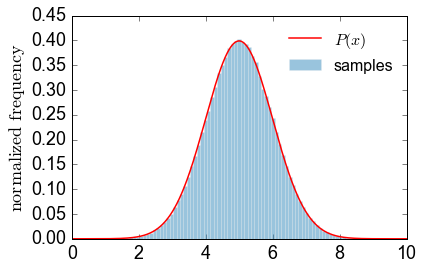

In [42]:
f = plt.figure(figsize = (6, 4))
ax = f.add_subplot(111)
ax.grid(False)

# histogram of the points
_ = ax.hist(samples, bins = np.linspace(0, 10, 100), alpha = 0.5, normed = True,
           label = 'samples')

# compare to P(x)
xx = np.linspace(0, 10, 1000)
ax.plot(xx, P(xx), 'r', label = r'$P(x)$')
ax.legend(frameon = False, fontsize = 16)
ax.set_ylabel(r'${\rm normalized\,frequency}$', fontsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
ax.yaxis.set_tick_params(labelsize = 18)

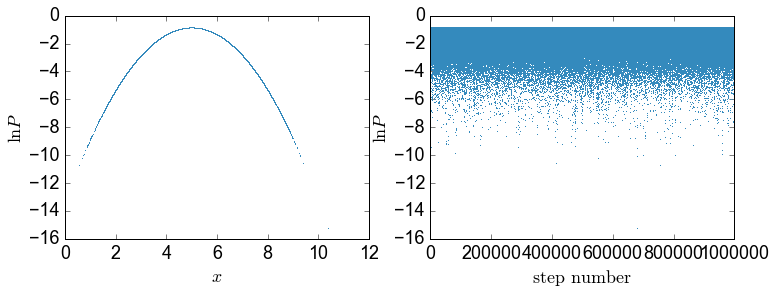

In [63]:
'''looks good. Let's make sure we're converging on a steady state 
(though it's pretty clear we are just from the above plot)'''

fig, ax = plt.subplots(1, 2, figsize = (12, 4))

labels = [r'$x$', r'${\rm step\,number}$']
for i in range(2):
    ax[i].grid(False)
    ax[i].xaxis.set_tick_params(labelsize = 18)
    ax[i].yaxis.set_tick_params(labelsize = 18)
    ax[i].set_ylabel(r'$\ln P$', fontsize = 18)
    ax[i].set_xlabel(labels[i], fontsize = 18)
    
x = samples
ax[0].plot(x, np.log(np.vectorize(P)(x)), ',')
ax[1].plot(np.arange(len(x)), np.log(np.vectorize(P)(x)), ',')

# not 100% clear what the point of these is. 